# Cell Type Prediction

There are different ways to predict cell types, e. g. using astir or argmax. The following notebook demonstrates some common ways of predicting cell types and subtypes

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spatialproteomics as sp
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.signal import medfilt2d
xr.set_options(display_style='text')

In [3]:
ds = xr.load_dataset('../../data/BNHL_166_4_I2_LK.zarr')
ds["_properties"] = ds["_labels"]
ds = ds.pp.drop_layers(["_labels", '_arcsinh_mean', '_arcsinh_sum', '_raw_mean', '_raw_sum'])

/opt/conda/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


## Image Processing

In [4]:
# preprocessing: thresholding by percentiles and applying a median filter
channels = ['PAX5', 'CD3', 'CD11b', 'CD11c', 'CD15', 'CD68', 'Podoplanin', 'CD31', 'CD34', 'CD90', 'CD56', 'CD4', 'CD8']
quantiles = [0.8, 0.5, 0.8, 0.8, 0.8, 0.8, 0.95, 0.95, 0.95, 0.95, 0.8, 0.8, 0.8]
colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#ffd8b1', '#f58231', '#911eb4', '#fffac8', '#469990', '#fabed4', '#9A6324', '#3cb44b', '#3cb44b']

channels_celltypes = channels[:-2]
colors_celltypes = colors[:-2]

# processing and recomputing quantification
ds_processed = ds.pp[channels].pp.threshold(quantiles).pp.apply(medfilt2d, kernel_size=3).pp.add_quantification().pp.transform_expression_matrix(method='arcsinh')

/opt/conda/lib/python3.10/site-packages/skimage/measure/_regionprops.py:317: UserWarning: Extra property 'mean_intensity' is shadowed by existing property and will be inaccessible. Consider renaming it.
  warn(msg)


Text(0.5, 1.0, 'Processed')

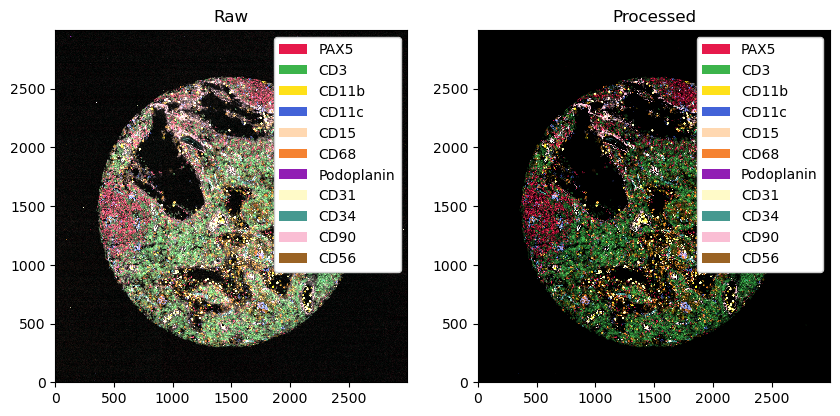

In [5]:
# plotting the ds and ds processed next to one another

# visualizing the raw vs the processed image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

_ = ds.pp[channels_celltypes].pl.colorize(colors_celltypes).pl.show(ax=ax[0])
_ = ds_processed.pp[channels_celltypes].pl.colorize(colors_celltypes).pl.show(ax=ax[1])

ax[0].set_title("Raw")
ax[1].set_title("Processed")

## Cell Type Prediction with Argmax

Given the thresholded image, the simplest way to derive cell type labels is to define associations between cell types and markers, and then assign the cell type whose marker is most highly expressed (i. e. taking the argmax). This is what is demonstrated below.

In [6]:
ct_marker_dict = {'B': 'PAX5', 'T': 'CD3', 'Myeloid': 'CD11b', 'Dendritic': 'CD11c', 'Granulo': 'CD15', 'Macro': 'CD68', 'Stroma PDPN': 'Podoplanin', 'Stroma CD31': 'CD31', 'Stroma CD34': 'CD34', 'Stroma CD90': 'CD90', 'NK': 'CD56'}

In [7]:
# predicting the cell type using the argmay
ds_with_ct_predictions = ds_processed.la.predict_cell_types_argmax(ct_marker_dict, key='_intensity', overwrite_existing_labels=True)

# adding colors to match the markers
ds_with_ct_predictions = ds_with_ct_predictions.la.set_label_colors(list(ct_marker_dict.keys()), colors_celltypes)

Label Stroma PDPN not found in the data object. Skipping.


Text(0.5, 1.0, 'Cell Type Predictions')

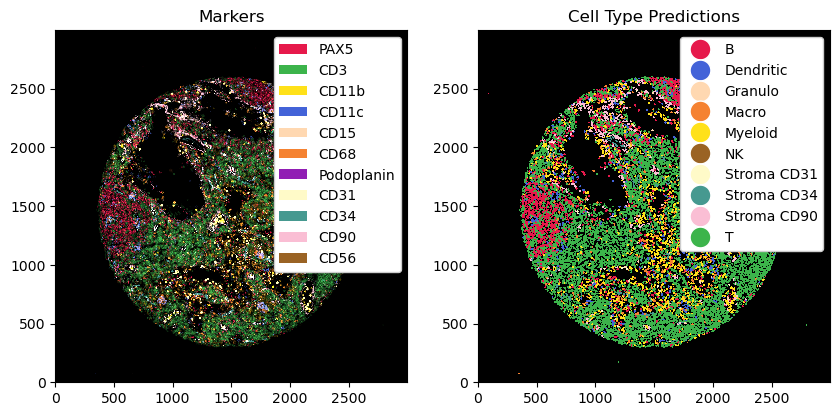

In [8]:
# plotting the ct predictions next to the processed image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

_ = ds_with_ct_predictions.pp[channels_celltypes].pl.colorize(colors_celltypes).pl.show(ax=ax[0])
_ = ds_with_ct_predictions.pl.show(render_image=False, render_labels=True, ax=ax[1])

ax[0].set_title("Markers")
ax[1].set_title("Cell Type Predictions")

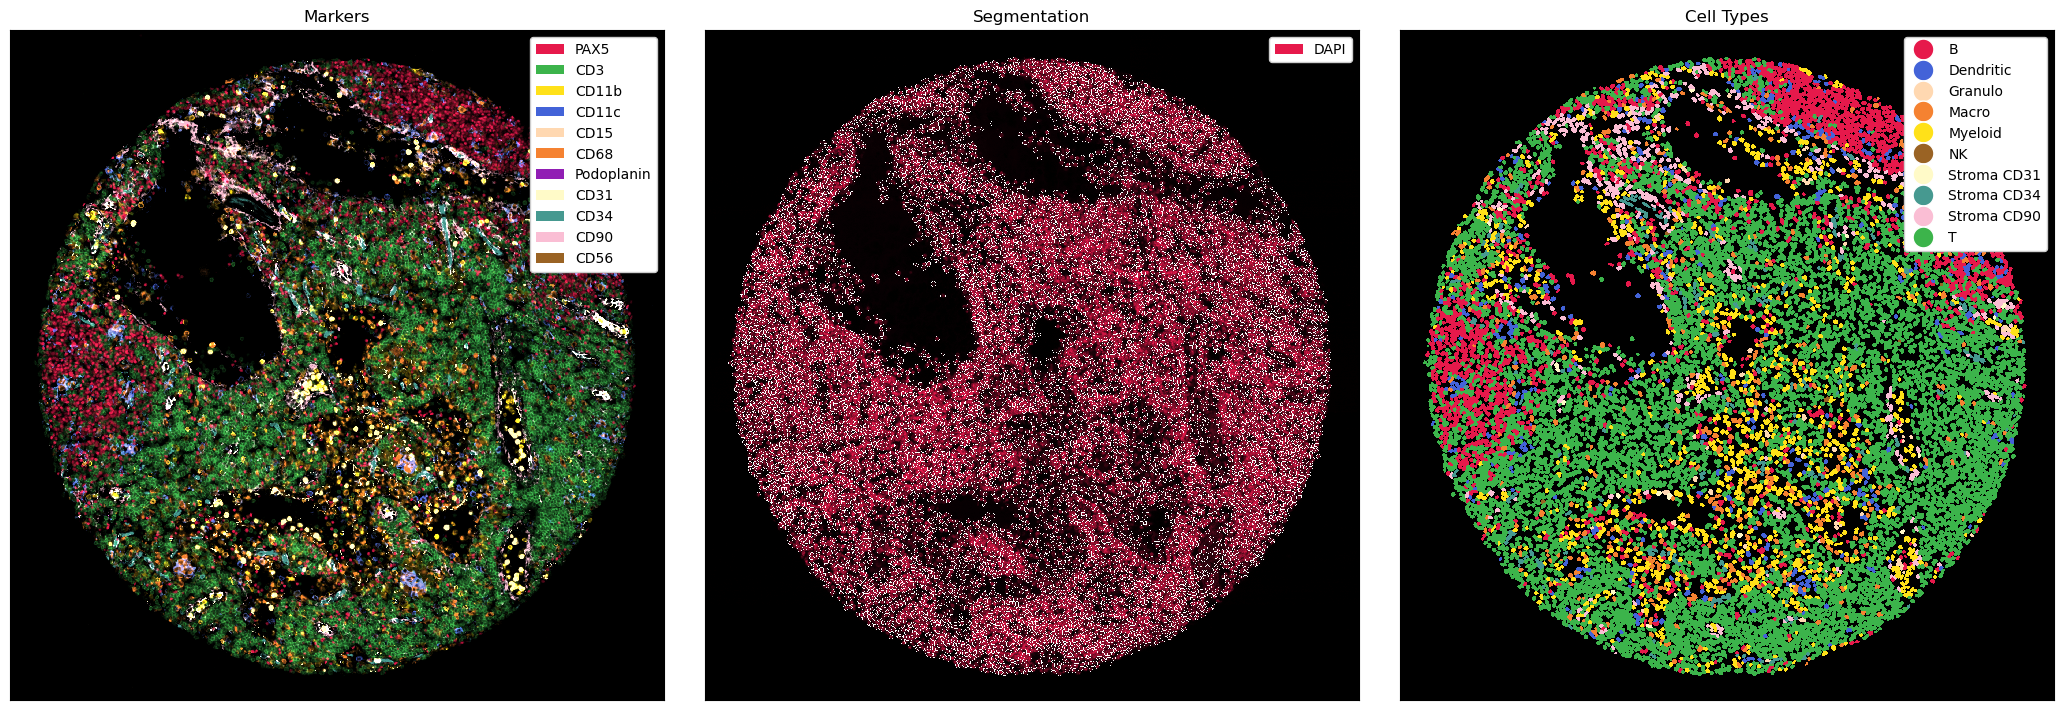

In [9]:
# this is how the image in the README was created
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
_ = ds_processed.pp[channels_celltypes].pl.colorize(colors_celltypes).pl.autocrop(padding=100).pl.show(ax=ax[0])
_ = ds.pp['DAPI'].pl.autocrop(padding=100).pl.show(render_segmentation=True, ax=ax[1])
_ = ds_with_ct_predictions.pl.autocrop(padding=100).pl.show(render_image=False, render_labels=True, ax=ax[2])


# removing the x and y ticks
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

# setting titles
ax[0].set_title('Markers')
ax[1].set_title('Segmentation')
ax[2].set_title('Cell Types')

plt.tight_layout()

Getting observations from the xarray object is very easy. However, since the cell types are stored as integers, the method `la.get_obs(celltypes_to_str=True)` allows you to export the obs in a more readable format.

In [10]:
# getting the obs with get_layer_as_df() to get human readable cell type annotations in a pandas data frame
ds_with_ct_predictions.pp.get_layer_as_df('_obs', celltypes_to_str=True)

_labels  _original_   centroid-0   centroid-1
1            T         3.0   613.329787   768.420213
2        Macro         5.0   769.098446   707.544041
3            T         2.0   774.528409   644.284091
4            T         3.0   775.902878   592.744604
5      Myeloid         5.0   668.844749   729.310502
...        ...         ...          ...          ...
12556        B         7.0  2340.362319  1846.492754
12557    Macro         5.0  2216.324138  2296.089655
12558        T         2.0  2265.910853  2231.992248
12559        B         7.0  2281.480687  2218.424893
12560        B         7.0  2249.069444  2236.564815

[12560 rows x 4 columns]

## Cell Type Prediction with Astir

There also exist more involved methods of predicting cell types, such as astir. Here is a quick example on how one could apply astir to the previous image.

In [11]:
ds_processed

<xarray.Dataset>
Dimensions:        (cells: 12560, features: 4, y: 3000, x: 3000, channels: 13,
                    labels: 8, props: 2)
Coordinates:
  * cells          (cells) int64 1 2 3 4 5 6 ... 12556 12557 12558 12559 12560
  * channels       (channels) <U11 'PAX5' 'CD3' 'CD11b' ... 'CD56' 'CD4' 'CD8'
  * features       (features) <U10 'centroid-0' 'centroid-1' ... '_original_'
  * labels         (labels) int64 1 2 3 4 5 6 7 8
  * props          (props) <U6 '_color' '_name'
  * x              (x) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * y              (y) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
Data variables:
    _obs           (cells, features) float64 613.3 768.4 4.0 ... 8.0 7.0
    _segmentation  (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    _properties    (labels, props) object 'C3' ... 'B (PAX5)'
    _image         (channels, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    _intensity     (cells, channels) float64 0.0 2.413 0.0 ... 0.3745 0.01481

In [12]:
# minor reformating
seg = ds_processed['_segmentation'].values
ds_for_astir = ds_processed.pp.drop_layers('_obs').pp.drop_layers('_properties').pp.add_segmentation(seg)

In [13]:
ds_for_astir

<xarray.Dataset>
Dimensions:        (channels: 13, x: 3000, y: 3000, cells: 12560, features: 2)
Coordinates:
  * channels       (channels) <U11 'PAX5' 'CD3' 'CD11b' ... 'CD56' 'CD4' 'CD8'
  * x              (x) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * y              (y) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * cells          (cells) int64 1 2 3 4 5 6 ... 12556 12557 12558 12559 12560
  * features       (features) <U10 'centroid-0' 'centroid-1'
Data variables:
    _image         (channels, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    _intensity     (cells, channels) float64 0.0 2.413 0.0 ... 0.3745 0.01481
    _segmentation  (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    _obs           (cells, features) float64 613.3 768.4 ... 2.249e+03 2.237e+03

In [15]:
# using astir to predict cell types
# note the slightly different structure of the marker dictionary
ct_marker_dict = {'cell_type': {'B': ['PAX5'], 'T': ['CD3'], 'Myeloid': ['CD11b'], 'Dendritic': ['CD11c'], 'Granulo': ['CD15'], 'Macro': ['CD68'], 'Stroma PDPN': ['Podoplanin'], 'Stroma CD31': ['CD31'], 'Stroma CD34': ['CD34'], 'Stroma CD90': ['CD90'], 'NK': ['CD56']}}
ds_with_ct_predictions_astir = ds_for_astir.tl.astir(ct_marker_dict)

The image is not of type uint8, which is required for astir to work properly. Use the dtype argument in add_quantification() to convert the image to uint8. If you applied operations such as filtering, you may ignore this warning.
training restart (final):   4%|▍         | 20/500 [ 3.51s/epochs, current loss: -72852.9]


In [16]:
# adding custom colors and adding observations back in
cell_types = ['B', 'T', 'Myeloid', 'Dendritic', 'Granulo', 'Macro', 'Stroma PDPN', 'Stroma CD31', 'Stroma CD34', 'Stroma CD90', 'NK', 'Other']
ds_with_ct_predictions_astir = ds_with_ct_predictions_astir.la.set_label_colors(cell_types, colors_celltypes + ['darkgray']).pp.add_observations()

In [17]:
ds_with_ct_predictions_astir

<xarray.Dataset>
Dimensions:        (labels: 12, props: 2, channels: 13, x: 3000, y: 3000,
                    cells: 12560, features: 3)
Coordinates:
  * labels         (labels) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * props          (props) <U6 '_color' '_name'
  * channels       (channels) <U11 'PAX5' 'CD3' 'CD11b' ... 'CD56' 'CD4' 'CD8'
  * x              (x) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * y              (y) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * cells          (cells) int64 1 2 3 4 5 6 ... 12556 12557 12558 12559 12560
  * features       (features) <U10 '_labels' 'centroid-0' 'centroid-1'
Data variables:
    _image         (channels, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    _intensity     (cells, channels) float64 0.0 2.413 0.0 ... 0.3745 0.01481
    _segmentation  (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    _obs           (cells, features) float64 12.0 613.3 ... 2.249e+03 2.237e+03
    _properties    (labels, props) object '#e6194B' 'B' ... '#3cb44b' 'T'

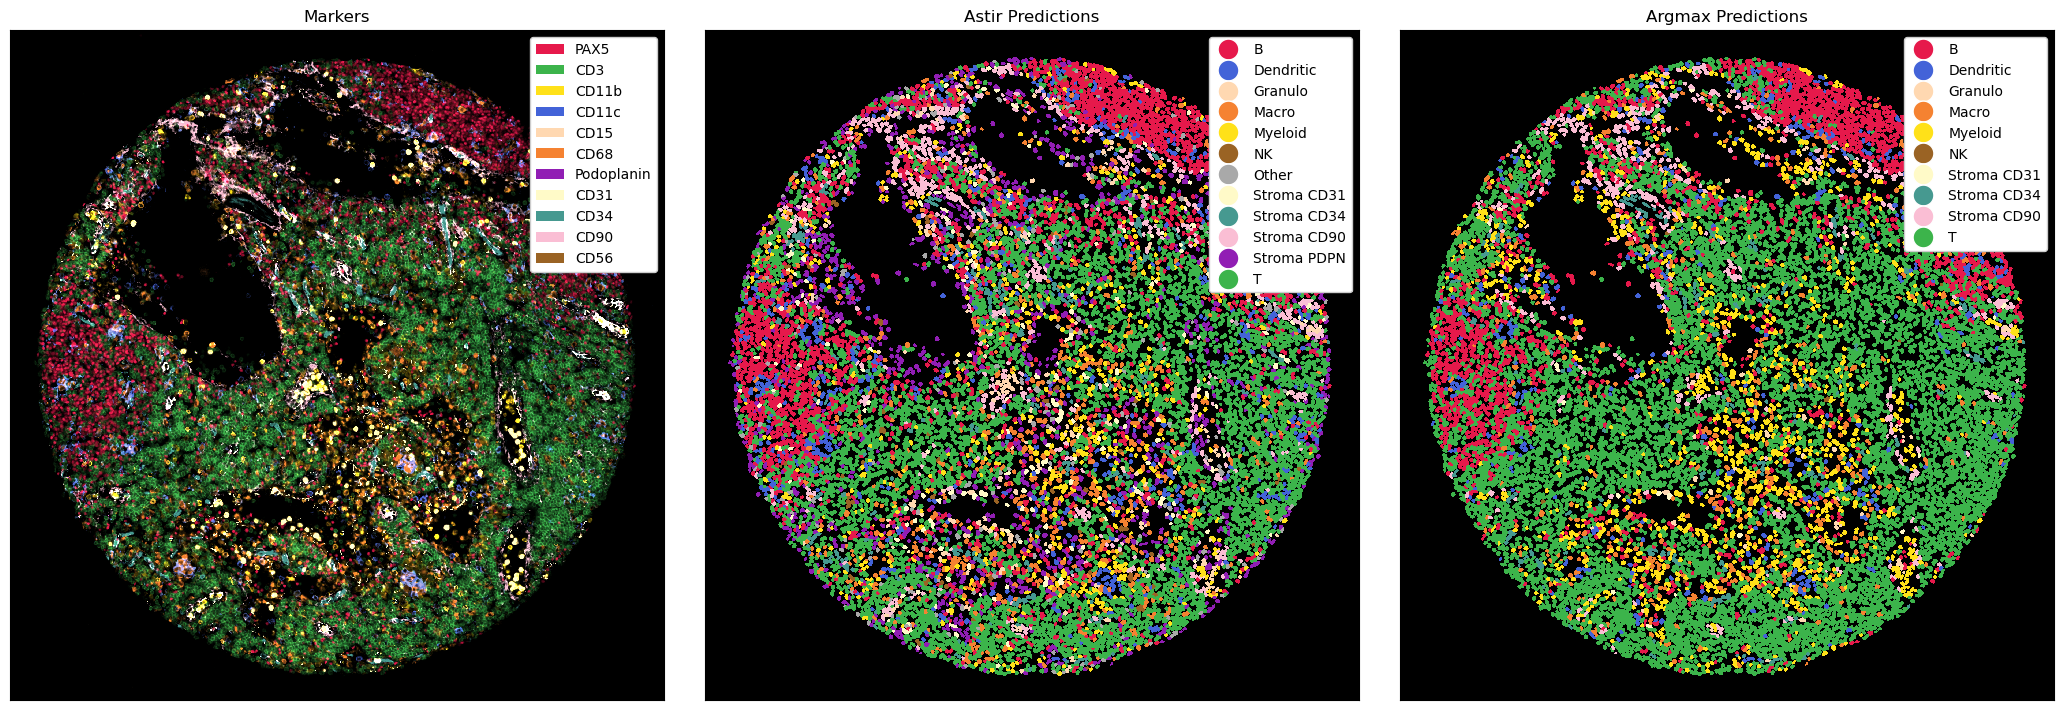

In [18]:
# plotting the astir and the argmax predictions
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
_ = ds_processed.pp[channels_celltypes].pl.colorize(colors_celltypes).pl.autocrop(padding=100).pl.show(ax=ax[0])
_ = ds_with_ct_predictions_astir.pl.autocrop(padding=100).pl.show(render_image=False, render_labels=True, ax=ax[1])
_ = ds_with_ct_predictions.pl.autocrop(padding=100).pl.show(render_image=False, render_labels=True, ax=ax[2])

# removing the x and y ticks
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

# setting titles
ax[0].set_title('Markers')
ax[1].set_title('Astir Predictions')
ax[2].set_title('Argmax Predictions')

plt.tight_layout()

## Marker Binarization

For some (functional) markers, we want to binarize them (i. e. is a cell positive or negative for that marker). This can be achieved with the `la.threshold_labels()` function.

In [19]:
ds_with_ct_predictions = ds_with_ct_predictions.pp.add_quantification(func=sp.percentage_positive, key_added='_percentage_positive')

In [20]:
# these thresholds are the percentages of positive cells required
threshold_dict = {
    "PAX5": 0.9,
    "CD3": 0.9,
    "CD4": 0.95,
    "CD8": 0.95,
}

ds_with_binarization = ds_with_ct_predictions.la.threshold_labels(threshold_dict, layer_key='_percentage_positive')

Text(0.5, 1.0, 'CD8 binarization')

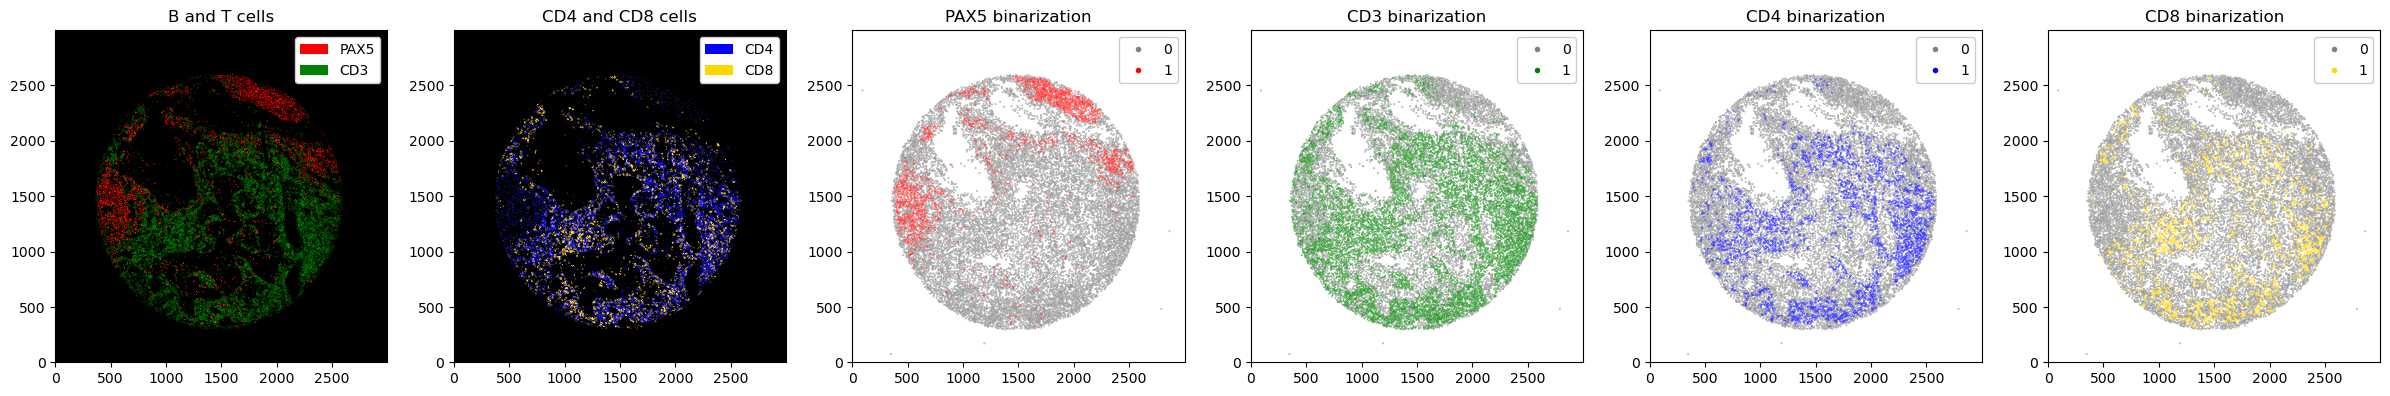

In [21]:
# plotting the binarization next to the marker intensities
fig, ax = plt.subplots(1, 6, figsize=(30, 5))

_ = ds_with_binarization.pp[['PAX5', 'CD3']].pl.colorize(['red', 'green']).pl.show(render_image=True, render_labels=False, ax=ax[0])
_ = ds_with_binarization.pp[['CD4', 'CD8']].pl.colorize(['blue', 'gold']).pl.show(render_image=True, render_labels=False, ax=ax[1])

_ = ds_with_binarization.pl.scatter(feature='PAX5_binarized', size=0.1, palette={0: 'gray', 1: 'red'}, ax=ax[2])
_ = ds_with_binarization.pl.scatter(feature='CD3_binarized', size=0.1, palette={0: 'gray', 1: 'green'}, ax=ax[3])
_ = ds_with_binarization.pl.scatter(feature='CD4_binarized', size=0.1, palette={0: 'gray', 1: 'blue'}, ax=ax[4])
_ = ds_with_binarization.pl.scatter(feature='CD8_binarized', size=0.1, palette={0: 'gray', 1: 'gold'}, ax=ax[5])

ax[0].set_title("B and T cells")
ax[1].set_title("CD4 and CD8 cells")
ax[2].set_title("PAX5 binarization")
ax[3].set_title("CD3 binarization")
ax[4].set_title("CD4 binarization")
ax[5].set_title("CD8 binarization")

We can also just subset from a single cell type. For example, consider a low CD4 threshold, once on all cells and once on only the T cells. For illustrative purposes, we have only applied a relaxed threshold (80-percentile) to CD4 previously. We also choose a very relaxed threshold here, just to show the concept of subsetting when binarizing a marker.

In [22]:
threshold_dict = {
    "CD4": 0.5
}

# in the first one, we binarize CD4 on all cells
ds_with_binarization_cd4 = ds_with_ct_predictions.la.threshold_labels(threshold_dict, layer_key='_percentage_positive')
# in the second one, we only look at CD4 in the T cells
ds_with_binarization_cd4_t = ds_with_ct_predictions.la.threshold_labels(threshold_dict, label='T', layer_key='_percentage_positive')

Text(0.5, 1.0, 'CD4 on T cells only')

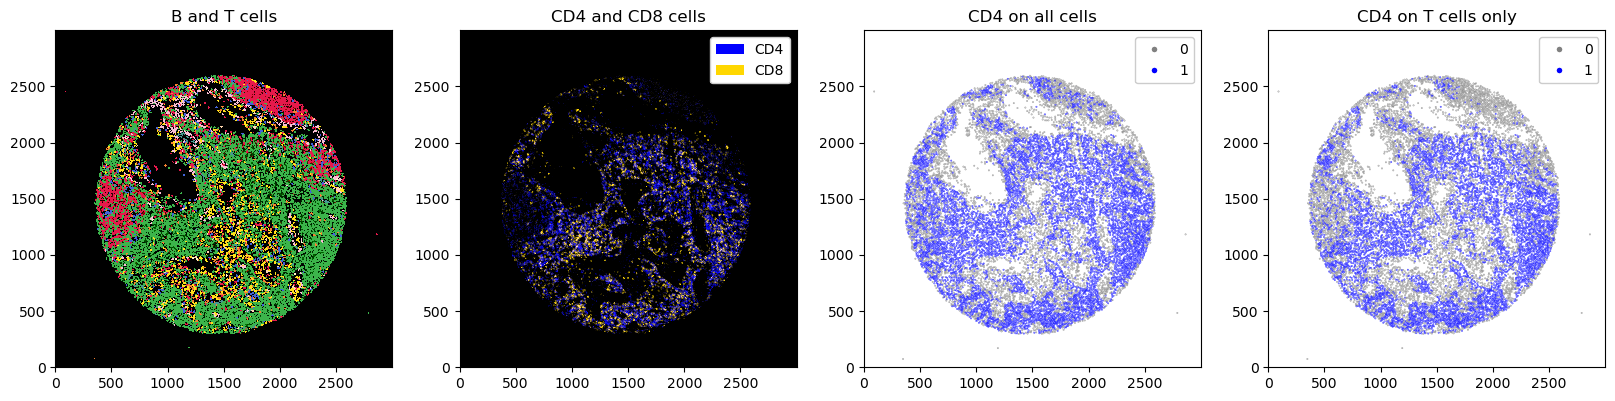

In [23]:
# plotting the binarization next to the marker intensities
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

_ = ds_with_binarization_cd4.pp[['PAX5', 'CD3']].pl.colorize(['red', 'green']).pl.show(render_image=False, render_labels=True, legend_label=False, ax=ax[0])
_ = ds_with_binarization_cd4.pp[['CD4', 'CD8']].pl.colorize(['blue', 'gold']).pl.show(render_image=True, render_labels=False, ax=ax[1])

_ = ds_with_binarization_cd4.pl.scatter(feature='CD4_binarized', size=0.1, palette={0: 'gray', 1: 'blue'}, ax=ax[2])
_ = ds_with_binarization_cd4_t.pl.scatter(feature='CD4_T_binarized', size=0.1, palette={0: 'gray', 1: 'blue'}, ax=ax[3])

ax[0].set_title("B and T cells")
ax[1].set_title("CD4 and CD8 cells")
ax[2].set_title("CD4 on all cells")
ax[3].set_title("CD4 on T cells only")